# Object Detection Using YOLO_v1 Model

In this notebook I am going use YOLO model to detect object in a given image.

Here in this notebook I am not going to train YOLO model I am just going to use
YOLO_v3 model weights and YOLO_v3 model configuration file to get trained YOLO_v3 model.


---

## YOLO Model
Let me tell You about YOLO

YOLO (You Only Look Once) is a real-time object detection algorithm that was introduced in 2016 by Joseph Redmon et al. It is known for its ability to detect and classify objects in images and videos with impressive speed while maintaining good accuracy.
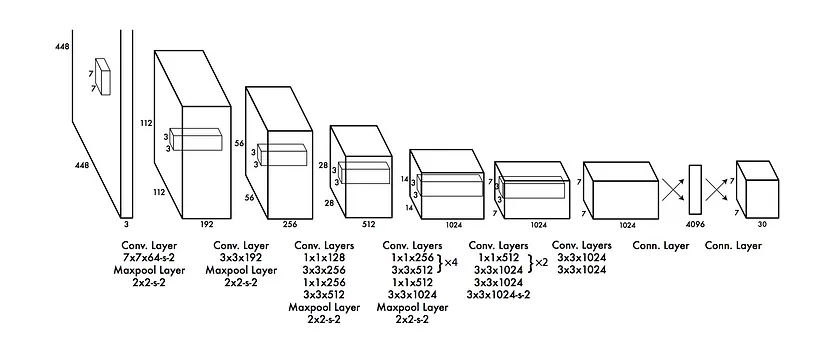
<caption><center> <u><b> Figure  </u></b>: YOLO_v1 Architecture(Frist YOLO model)<br> </center></caption>







The key idea behind YOLO is to treat object detection as a regression problem. Rather than using traditional region proposal methods, YOLO divides an input image into a grid and directly predicts bounding boxes and class probabilities within each grid cell. This means that object detection is performed in a single pass of the network, resulting in real-time inference speeds.

Here are some key features and characteristics of YOLO:

* Single pass detection: YOLO performs object detection by predicting bounding boxes and class probabilities directly from the input image in a single forward pass of the network. This allows it to be very fast compared to multi-stage approaches.

* Grid-based approach: YOLO divides the input image into a grid of cells. Each cell is responsible for predicting bounding boxes and class probabilities for objects that fall within it.

* Bounding box predictions: YOLO predicts bounding boxes by regressing the coordinates of the box relative to the cell it belongs to. Each bounding box prediction consists of the coordinates (x, y) of the box's center, its width (w), height (h), and a confidence score indicating the likelihood of containing an object.

* Class predictions: YOLO also predicts class probabilities for each bounding box. It assigns class probabilities independently for each box, allowing it to handle multiple objects of different classes in the same grid cell.

* Non-maximum suppression: After generating a large number of bounding box predictions, YOLO applies non-maximum suppression to eliminate redundant detections and retain only the most confident ones.

* Trade-off between speed and accuracy: YOLO is designed to achieve real-time object detection, making it suitable for applications that require fast inference. However, this can come at the cost of slightly lower accuracy compared to slower, multi-stage detection methods.

* Since its introduction, YOLO has gone through several iterations and improvements, such as YOLOv2, YOLOv3, and YOLOv4. Each version has introduced enhancements to improve accuracy, handle smaller objects, and incorporate architectural improvements.

* YOLO has been widely adopted in various domains, including autonomous driving, surveillance systems, robotics, and more, where real-time object detection is crucial. It has become a popular choice due to its balance between speed and accuracy, making it suitable for applications with strict latency requirements.

## Required Libraries

In [40]:
# Importing libraries
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### Model

I have already downloaded
* YOLOv3 weights (<a href="https://pjreddie.com/media/files/yolov3.weights">download</a> YOLOv3.weights)
* YOLOv3 configuratiion  (<a href="https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg">download</a> YOLOv3.cfg)
* COCO names contains the names of the categories in the COCO (Common Objects in Context) dataset (<a href="https://www.kaggle.com/datasets/valentynsichkar/yolo-coco-data">download</a> coco.names)




For more visit <a href="https://pjreddie.com/darknet/yolo/"> yolo's official website</a>

In [41]:
yolov3_config_path = "drive/MyDrive/YOLOv3/yolov3.cfg"
yolov3_weights_path = "drive/MyDrive/YOLOv3/yolov3.weights"
coco_names_path = "drive/MyDrive/YOLOv3/coco.names"

Loading model `yolo_v3` using opencv

`cv.dnn.readNet()`function is provided by OpenCV to load neural network models.

In [42]:
yolo_v3 = cv.dnn.readNet(yolov3_config_path , yolov3_weights_path)

Fetching class names from COCO names files

In [43]:
classes = []
with open(coco_names_path , "r") as f:
  classes=f.read().splitlines()

In [44]:
len(classes)

80

### Importing Image

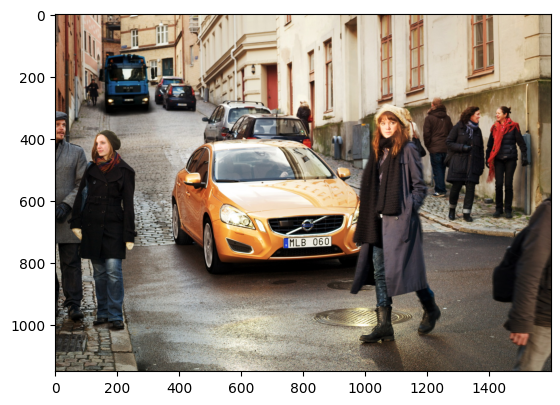

In [45]:
img = cv.imread("drive/MyDrive/YOLOv3/car.jpg")
img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Preprocessing image
using opencv to convert image to blob

A **blob** refers to a preprocessed image or a multi-channel tensor that is used as input to a neural network.


In [46]:
blob = cv.dnn.blobFromImage(img , 1/255 , (416,416) , swapRB = True , crop = False)

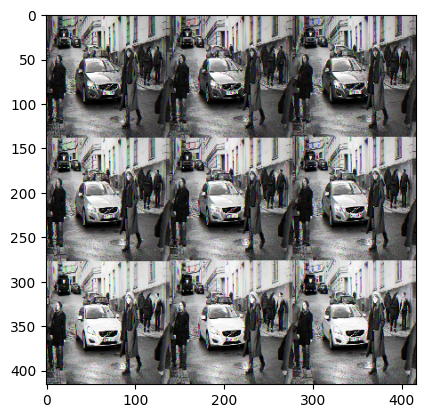

In [47]:
i = blob[0].reshape(416,416 ,3)
plt.imshow(i)

Setting blob as an input for our `yolo_v3` model

In [48]:
yolo_v3.setInput(blob)

The `getUnconnectedOutLayersNames()` method is a function provided by the framework to retrieve the names of the output layers that are not connected to any subsequent layers.

By obtaining the names of the unconnected output layers, it becomes possible to manipulate or extract the outputs of those layers separately, which can be useful in detection.


The  `output_layer = net.forward()` is used to perform a forward pass through the neural network model net and obtain the outputs of the specified output layers.

The **output_layer_names** is a list of names of the specific output layers for which we want to retrieve the outputs. By passing output_layer_names as an argument to the `forward()` method, the neural network computes the outputs of those layers.

In [49]:
output_layer_names = yolo_v3.getUnconnectedOutLayersNames()
output_layer = yolo_v3.forward(output_layer_names)

After executing the code below,
 * The `class_ids` list will contain the predicted class IDs of the detected object
 * The `confidences` list will contain their corresponding confidences
 * The `boxes` list will contain the bounding box coordinates (x, y, width, height) of the objects.

 These lists will be then be used for  visualization of the object detections.

In [50]:
height , width = img.shape[:2] # height & width of imported image
boxes = []
confidences = []
class_ids = []
for output in output_layer:
  for detection in output:
    score = detection[5:]
    class_id=np.argmax(score) # maximum scored class index
    confidence =  score[class_id]
    if confidence >0.7:
      center_x = int(detection[0]*width)
      center_y = int(detection[1]*height)
      w = int(detection[2]*width)
      h = int(detection[3]*height)
      x = int(center_x -w/2)
      y = int(center_y -h/2)
      class_ids.append(class_id)
      confidences.append(float(confidence))
      boxes.append([x,y,w,h])

In [51]:
len(boxes)

32

Lets perform Non-Maximum Suppression (NMS) algorithm to filter out overlapping bounding box detections and return the indexes of the selected bounding boxes.

In [52]:
indexes = cv.dnn.NMSBoxes(boxes , confidences ,0.5 , 0.4 )

### Visualising

* Adding boxes and label to the real image

Visualising the performed object detection result

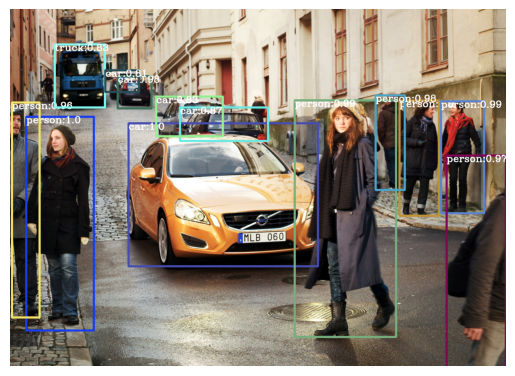

In [53]:
colors = np.random.uniform(0 , 255 , size=(len(boxes),3))
font = cv.FONT_HERSHEY_COMPLEX
for i in indexes.flatten():
  x, y , w, h = boxes[i]
  confi = str(round(confidences[i] , 2))
  label = str(classes[class_ids[i]])
  color = colors[i]
  cv.rectangle(img , (int(x),int(y)) , (int(x+w),int(y+h)) , color , 5)
  cv.putText(img , label+":"+confi , (int(x),int(y+20)),font, 1 , [255,255,255],2)
plt.axis("off")
plt.imshow(img)
plt.show()


Here it is ......

## Objection detection function

`detect_objects_in_image` is a function to perform image detection on a given images



In [82]:
def detect_objects_in_image(image_path):
  """ This function takes image path and performs object detection on it
  This function returns the object detected image
  """
  img = cv.imread(image_path)
  img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
  blob = cv.dnn.blobFromImage(img , 1/255 ,(416,416), swapRB=True , crop=False)
  yolo_v3.setInput(blob)
  output_layers_names=yolo_v3.getUnconnectedOutLayersNames()
  output_layers = yolo_v3.forward(output_layers_names)
  height ,width = img.shape[:2]
  boxes=[]
  confidences=[]
  class_ids=[]
  for output in output_layers:
    for detection in output:
      score = detection[5:]
      class_id = np.argmax(score)
      confidence = score[class_id]
      if confidence > 0.7:
        x_center = int(detection[0]*width)
        y_center = int(detection[1]* height)
        w = int(detection[2]*width)
        h = int(detection[3]*height)
        x = int(x_center -w/2)
        y = int(y_center -h/2)
        boxes.append([x,y,w,h])
        confidences.append(float(confidence))
        class_ids.append(class_id)
  indexes = cv.dnn.NMSBoxes(boxes , confidences , 0.5 , 0.4)
  colors = np.random.uniform(0 , 255 , size =(len(boxes),3))
  font = cv.FONT_HERSHEY_PLAIN
  for i in indexes.flatten():
    x,y,w,h = boxes[i]
    confi = str(round(confidences[i],2))
    label = str(classes[class_ids[i]])
    color = colors[i]
    cv.rectangle(img , (int(x),int(y)) , (int(x+w),int(y+h)),color , 4)
    cv.putText(img , label+":"+confi , (int(x),int(y+20)),font,1,color ,2)
  plt.axis("off")
  plt.imshow(img)
  plt.show()


Object Detection using `detect_objects_in_image` function

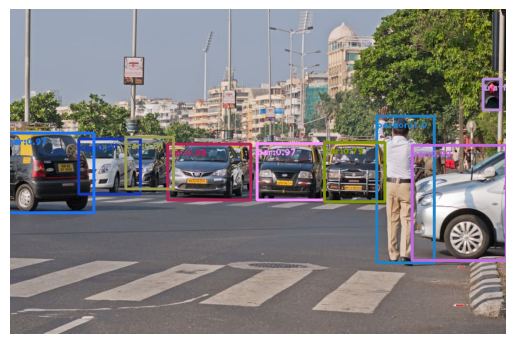

In [83]:
detect_objects_in_image("drive/MyDrive/YOLOv3/feature.jpg")

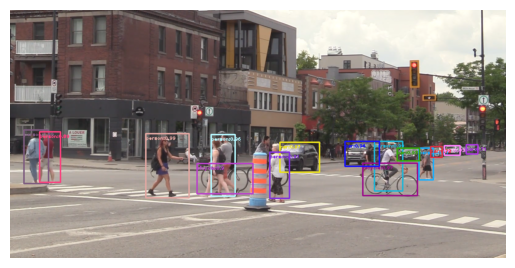

In [84]:
detect_objects_in_image("/content/drive/MyDrive/YOLOv3/raod1.png")

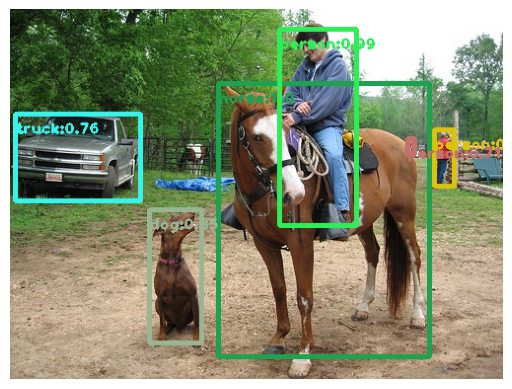

In [85]:
detect_objects_in_image("/content/drive/MyDrive/YOLOv3/horse.jpg")